In [504]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
# we import funcanimation from the matplotlib library
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap, TwoSlopeNorm
from IPython.display import HTML
import ccxt
import datetime
import pandas as pd
from pycoingecko import CoinGeckoAPI
import pandas as pd
from datetime import datetime, timedelta
# we hide warnings in the notebook
import warnings
warnings.filterwarnings('ignore')
import time
from scipy.ndimage import gaussian_filter1d
import imageio
import matplotlib.dates as mdates


In [4]:
from datetime import datetime

def convert_unix_to_datetime(unix_timestamp):
    # Convert Unix timestamp to datetime object
    dt = datetime.utcfromtimestamp(unix_timestamp)
    converted_datetime_str = dt.strftime('%Y-%m-%d')
    return dt

# Example usage
unix_timestamp = 1631021642  # Example Unix timestamp
converted_datetime = convert_unix_to_datetime(unix_timestamp)
print(f"Unix Timestamp: {unix_timestamp}")
print(f"Converted Datetime (UTC): {converted_datetime}")
# we also return a string with the date in the format YYYY-MM-DD
converted_datetime_str = converted_datetime.strftime('%Y-%m-%d')
print(f"Converted Datetime (UTC) as string: {converted_datetime_str}")


Unix Timestamp: 1631021642
Converted Datetime (UTC): 2021-09-07 13:34:02
Converted Datetime (UTC) as string: 2021-09-07


In [5]:
from datetime import datetime

def unix_timestamp_to_date(unix_timestamp):
    """
    Convert a Unix timestamp to a date (without time).

    Parameters:
    - unix_timestamp: An integer or float representing the Unix timestamp.

    Returns:
    - A datetime.date object representing the date.
    """
    # Convert the Unix timestamp to a datetime object
    dt_object = datetime.utcfromtimestamp(unix_timestamp)
    
    # Extract and return just the date part
    return dt_object.date()

# Example usage:
unix_timestamp = 1708128000  # Example Unix timestamp
date = unix_timestamp_to_date(unix_timestamp)
print(f"Date: {date}")


Date: 2024-02-17


In [6]:

cg = CoinGeckoAPI()

def fetch_historical_data(coin_id, days='max', interval='daily'):
    """
    Fetch historical market data for a specific coin from CoinGecko.
    
    :param coin_id: The CoinGecko ID of the coin (e.g., 'bitcoin').
    :param days: The number of days of historical data to fetch ('max' for as much as possible).
    :param interval: The interval of the data ('daily').
    :return: A DataFrame with the historical data.
    """
    data = cg.get_coin_market_chart_by_id(id=coin_id, vs_currency='usd', days=days, interval=interval)
    # print(data['prices'])
    # print(data['prices'][0])
    dates = [unix_timestamp_to_date(ms[0]/1000) for ms in data['prices']]
    # print(dates)
    prices = [price[1] for price in data['prices']]
    # print(prices)
    # we convert timestamp 1550707200000 to datetime
    # datetime.fromtimestamp(1708128000000/1000.0)
    # print(datetime.fromtimestamp(1550707200000/1000.0))
    # print(pd.to_datetime(1708128000000/1000).date().strftime('%Y-%m-%d'))
    
    df = pd.DataFrame(data={'date': dates, 'price': prices})
    return df

# # Example usage:
# coin_id = 'bitcoin'  # Use the CoinGecko ID for the cryptocurrency
# data = fetch_historical_data(coin_id, days='3')  # Last 5 years
# print(data.head(10))

# Note: To fetch data for the top 100 crypto assets, you would need to know their CoinGecko IDs.
# You can use `cg.get_coins_markets(vs_currency='usd')` to fetch a list of coins with their IDs,
# and then iterate over the ones you're interested in.


In [7]:
#  we retrieve 5 years of data for the following coins: 'bitcoin', 'ethereum', 'ripple', 'litecoin', 'dogecoin'
coins = ['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']

prices_df_0 = pd.DataFrame(columns=['date', 'price', 'coin'])

for coin in coins:
    historical_data = fetch_historical_data(coin, days='3000')
    # we get rid of the last reading as it is today's price and it is not complete
    historical_data = historical_data.iloc[:-1]
    historical_data['coin'] = coin
    prices_df_0 = pd.concat([prices_df_0, historical_data])
    # we sleep for 1 second to avoid hitting the CoinGecko API rate limits
    time.sleep(1)

prices_df_0.tail(10)

,date,price,coin
2285,2024-02-11,18.943746,chainlink
2286,2024-02-12,20.111251,chainlink
2287,2024-02-13,20.496025,chainlink
2288,2024-02-14,19.878042,chainlink
2289,2024-02-15,20.266400,chainlink
2290,2024-02-16,19.947655,chainlink
2291,2024-02-17,19.567520,chainlink
2292,2024-02-18,20.033304,chainlink
2293,2024-02-19,20.089966,chainlink
2294,2024-02-20,19.823360,chainlink


In [8]:
# we pivot the dataframe and get the coin into columns
prices_pivot = prices_df_0.pivot(index='date', columns='coin', values='price')
prices_pivot.tail(10)

coin,bitcoin,chainlink,ethereum,solana,uniswap
date,,,,,
2024-02-11,47768.995251,18.943746,2499.492184,108.991461,6.624057
2024-02-12,48189.881793,20.111251,2505.076808,107.423813,6.673340
2024-02-13,50050.136095,20.496025,2657.990408,112.036818,6.843330
2024-02-14,49732.145370,19.878042,2641.536097,112.599112,6.693592
2024-02-15,51790.169298,20.266400,2780.372975,116.976107,6.873956
2024-02-16,51958.230291,19.947655,2826.821476,113.599394,7.497789
2024-02-17,52166.434310,19.567520,2807.371703,110.501551,7.451381
2024-02-18,51684.517493,20.033304,2788.561332,108.928510,7.754282
2024-02-19,52138.485789,20.089966,2874.945276,112.215416,7.640406


In [9]:
# prices_pivot.head()
# reset the index in place to get the date as a column
prices_pivot.reset_index(inplace=True)
prices_pivot.head()

coin,date,bitcoin,chainlink,ethereum,solana,uniswap
0,2015-12-05,NaN,NaN,0.864584,NaN,NaN
1,2015-12-06,394.011,NaN,0.834992,NaN,NaN
2,2015-12-07,394.355,NaN,0.800750,NaN,NaN
3,2015-12-08,412.930,NaN,0.818853,NaN,NaN
4,2015-12-09,417.368,NaN,0.791829,NaN,NaN


In [10]:
def get_daily_returns(returns_df,coin):
    daily_returns = returns_df.copy()
    # for each row we calculate how many days since date of previous row
    daily_returns['days_since'] = daily_returns['date'].diff().dt.days
    # we calculate the daily return by undoing the cumulative product
    # for each row after the first one, we calculate the daily return as the nth root of the cumulative (1 + return) product
    daily_returns['gross_return'] = daily_returns[coin] / daily_returns[coin].shift(1)
    daily_returns['daily_return'] = daily_returns['gross_return'] ** (1 / daily_returns['days_since'])-1
    # we check if the daily return is correct by calculating the cumulative product doing (1 + daily_return	) ** days_since
    # daily_returns['gross_check'] = ( daily_returns['daily_return']) ** daily_returns['days_since']
    # we fill the first row with 1
    # daily_returns['daily_return'].iloc[0] = 1
    
    # return daily_returns
    return daily_returns['daily_return'].to_list()


# get_daily_returns(merged_df[['Date','spy_close']]).head()
# print(get_daily_returns(merged_df[['Date','spy_close']]))
    

    

In [11]:
# for each column in the dataframe we calculate the daily returns and add them as a new column with the name of the coin
for coin in coins:
    coin = coin 
    prices_pivot[f'{coin}_daily_return'] = get_daily_returns(prices_pivot[['date', coin]],coin)
    # we also add the daily log1p return which we take from the daily return that we have just calculated
    prices_pivot[f'{coin}_daily_log1p_return'] = np.log1p(prices_pivot[f'{coin}_daily_return'])

prices_pivot.head(10)

coin,date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
0,2015-12-05,NaN,NaN,0.864584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-06,394.011,NaN,0.834992,NaN,NaN,NaN,NaN,-0.034226,-0.034825,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-07,394.355,NaN,0.800750,NaN,NaN,0.000873,0.000873,-0.041009,-0.041874,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-08,412.930,NaN,0.818853,NaN,NaN,0.047102,0.046027,0.022607,0.022355,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09,417.368,NaN,0.791829,NaN,NaN,0.010748,0.010690,-0.033001,-0.033558,NaN,NaN,NaN,NaN,NaN,NaN
5,2015-12-10,416.910,NaN,0.847442,NaN,NaN,-0.001097,-0.001098,0.070233,0.067877,NaN,NaN,NaN,NaN,NaN,NaN
6,2015-12-11,452.415,NaN,0.916739,NaN,NaN,0.085162,0.081730,0.081772,0.078600,NaN,NaN,NaN,NaN,NaN,NaN
7,2015-12-12,434.903,NaN,0.971258,NaN,NaN,-0.038708,-0.039477,0.059471,0.057770,NaN,NaN,NaN,NaN,NaN,NaN
8,2015-12-13,435.815,NaN,0.958303,NaN,NaN,0.002097,0.002095,-0.013339,-0.013428,NaN,NaN,NaN,NaN,NaN,NaN
9,2015-12-14,443.277,NaN,0.995490,NaN,NaN,0.017122,0.016977,0.038805,0.038071,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#  we plot the daily returns for the 5 coins
fig = go.Figure()
for coin in coins:
    fig.add_trace(go.Scatter(x=prices_pivot['date'], y=prices_pivot[f'{coin}_daily_return'], mode='lines', name=coin))
fig.update_layout(title='Daily Returns', xaxis_title='Date', yaxis_title='Daily Return')
fig.show()


In [13]:
# we merge the two dataframes on the date column
# we make both date columns date only
# spy_df["Date"] = spy_df["Date"].dt.date
# btc_df_source["Date"] = btc_df_source["Date"].dt.date

# merged_df = pd.merge(spy_df, btc_df_source, on="Date", how="outer")
# we drop the na values
# merged_df = merged_df.dropna()
# we only keep the daily returns columns
# merged_df = merged_df[["Date", "spy_daily_return", "btc_daily_return"]]
# we rename the columns Close_x and Close_y to spy_close and btc_close
# merged_df = merged_df.rename(columns={"Close_x": "spy_close", "Close_y": "btc_close"})
merged_df = prices_pivot
merged_df.tail(10)

coin,date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
2990,2024-02-11,47768.995251,18.943746,2499.492184,108.991461,6.624057,0.013273,0.013186,0.004679,0.004668,0.018288,0.018123,-0.005255,-0.005268,0.025008,0.024700
2991,2024-02-12,48189.881793,20.111251,2505.076808,107.423813,6.673340,0.008811,0.008772,0.002234,0.002232,-0.014383,-0.014488,0.007440,0.007412,0.061630,0.059806
2992,2024-02-13,50050.136095,20.496025,2657.990408,112.036818,6.843330,0.038603,0.037876,0.061041,0.059251,0.042942,0.042046,0.025473,0.025154,0.019132,0.018952
2993,2024-02-14,49732.145370,19.878042,2641.536097,112.599112,6.693592,-0.006353,-0.006374,-0.006191,-0.006210,0.005019,0.005006,-0.021881,-0.022124,-0.030151,-0.030615
2994,2024-02-15,51790.169298,20.266400,2780.372975,116.976107,6.873956,0.041382,0.040549,0.052559,0.051224,0.038872,0.038136,0.026946,0.026589,0.019537,0.019349
2995,2024-02-16,51958.230291,19.947655,2826.821476,113.599394,7.497789,0.003245,0.003240,0.016706,0.016568,-0.028867,-0.029292,0.090753,0.086868,-0.015728,-0.015853
2996,2024-02-17,52166.434310,19.567520,2807.371703,110.501551,7.451381,0.004007,0.003999,-0.006880,-0.006904,-0.027270,-0.027649,-0.006190,-0.006209,-0.019057,-0.019241
2997,2024-02-18,51684.517493,20.033304,2788.561332,108.928510,7.754282,-0.009238,-0.009281,-0.006700,-0.006723,-0.014235,-0.014338,0.040650,0.039846,0.023804,0.023525
2998,2024-02-19,52138.485789,20.089966,2874.945276,112.215416,7.640406,0.008783,0.008745,0.030978,0.030508,0.030175,0.029729,-0.014686,-0.014794,0.002828,0.002824
2999,2024-02-20,51764.313185,19.823360,2943.723085,111.278089,7.700477,-0.007177,-0.007202,0.023923,0.023641,-0.008353,-0.008388,0.007862,0.007832,-0.013271,-0.013359


In [14]:
def get_pdf(data, bins, min_x=-0.4, max_x=0.4):
    bin_edges = np.linspace(min_x, max_x, bins + 1)  # bins + 1 because np.linspace includes both ends
    # data = np.clip(data, min_x, max_x)  # Clip the data to the range
    counts, _ = np.histogram(data, bins=bin_edges, density=True)  # Use density=True for PDF
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_width = bin_edges[1] - bin_edges[0]  # Width of each bin
    counts = counts / counts.sum()

    return bin_centers, counts, bin_width

def find_month_starts(df, num_months=24):
    end_date = df['Date'].max()
    start_date = end_date - pd.DateOffset(months=num_months)
    month_starts = pd.date_range(start=start_date, end=end_date, freq='MS')
    # make sure the date is a datetime and not a timestamp
    month_starts = month_starts.to_pydatetime()
    # print(month_starts)
    return month_starts

def percentage_formatter(x, pos):
    return '{:0.0f}%'.format(x*100)

In [15]:
# we try the new method of calculating annual returns using the daily returns and a monter carlo simulation

def generate_random_daily_returns_from_pdf(bin_centers, bin_counts, size=(500, 365)):
    # print('bin_centers:', bin_centers)
    # print('99 bin_counts:', bin_counts)
    probabilities = bin_counts / np.sum(bin_counts)
    daily_returns = np.random.choice(bin_centers, size=size, p=probabilities)
    return daily_returns

def simulate_annual_returns(daily_returns):
    annual_returns = np.prod(1 + daily_returns, axis=1) - 1
    return annual_returns

def get_annual_returns_pdf(annual_returns, bins=30):
    # Calculate the histogram of annual returns
    counts, bin_edges = np.histogram(annual_returns, bins=bins, density=True)
    # Calculate bin centers from edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0] 
    return bin_centers, counts, bin_width


In [16]:
merged_df.head()

coin,date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
0,2015-12-05,NaN,NaN,0.864584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-06,394.011,NaN,0.834992,NaN,NaN,NaN,NaN,-0.034226,-0.034825,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-07,394.355,NaN,0.800750,NaN,NaN,0.000873,0.000873,-0.041009,-0.041874,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-08,412.930,NaN,0.818853,NaN,NaN,0.047102,0.046027,0.022607,0.022355,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09,417.368,NaN,0.791829,NaN,NaN,0.010748,0.010690,-0.033001,-0.033558,NaN,NaN,NaN,NaN,NaN,NaN


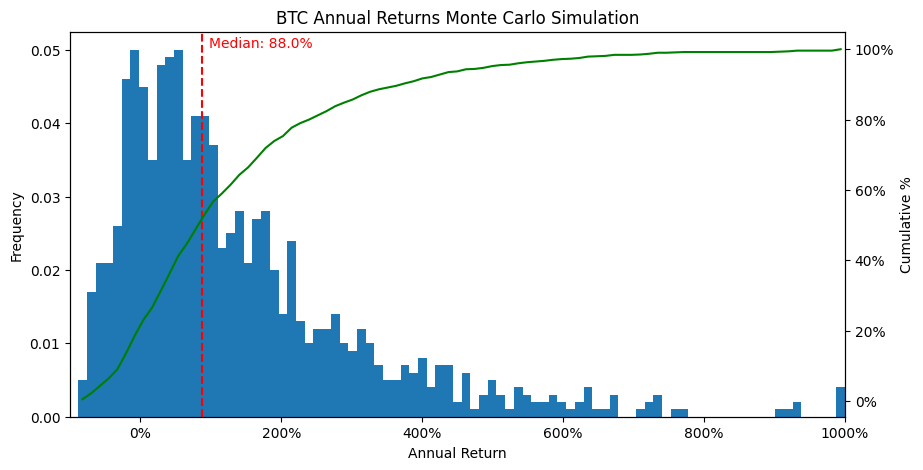

In [17]:
bins_daily = 600
bins_yearly = 88
tail = 3000
montecarlo_simulations = 1000
iterations_in_a_year = 365
min_x = -1
max_x = 10
min_x_daily = -0.5
max_x_daily = 1


bin_centers, bin_counts, bin_width = get_pdf(merged_df['bitcoin_daily_return'].tail(tail), bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
daily_montecarlo_returns = generate_random_daily_returns_from_pdf(bin_centers, bin_counts, size=(montecarlo_simulations, iterations_in_a_year))
annual_returns = simulate_annual_returns(daily_montecarlo_returns)
annual_returns = np.clip(annual_returns, min_x, max_x)
annual_centers, annual_counts, annual_width = get_annual_returns_pdf(annual_returns, bins=bins_yearly)
# we normalize the counts
annual_counts = annual_counts / annual_counts.sum()
# we clip the annual_centers between -1 and 2


# we add the cum_pct as a plot measured on the right y-axis
fig, ax = plt.subplots()

# we make the plot size bigger
fig.set_size_inches(10, 5)

ax.bar(annual_centers, annual_counts, width=annual_width)
ax.set_title('BTC Annual Returns Monte Carlo Simulation')
ax.set_xlabel('Annual Return')
ax.set_ylabel('Frequency')

# we add vertical bar for the 50th percentile
ax.axvline(np.percentile(annual_returns, 50), color='r', linestyle='--', label='50th percentile')
# we annotate the 50th percentile
median = np.percentile(annual_returns, 50)
ax.text(np.percentile(annual_returns, 50)*1.1, annual_counts.max(), 'Median: {:0.1%}'.format(median), rotation=0, verticalalignment='bottom', c='r')

# we calculate the cumulative percentage
cum_pct = np.cumsum(annual_counts)
# we plot the cumulative percentage
ax2 = ax.twinx()
ax2.plot(annual_centers, cum_pct, color='green', label='Cumulative %')
ax2.set_ylabel('Cumulative %')
ax2.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
ax.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
# we set xlim from -1 to 5
ax.set_xlim(min_x, max_x)
# ax.set_ylim(0, bins/200) 
plt.show()


In [445]:

def get_stochastic_annual_median_return(merged_df, montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily=600, bins_yearly=88):
    # print(merged_df.tail(tail))
    bin_centers_btc, bin_counts_btc, bin_width_btc = get_pdf(merged_df, bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
    daily_montecarlo_returns_btc = generate_random_daily_returns_from_pdf(bin_centers_btc, bin_counts_btc, size=(montecarlo_simulations, iterations_in_a_year))
    annual_returns_btc = simulate_annual_returns(daily_montecarlo_returns_btc)
    annual_returns_btc_clipped = np.clip(annual_returns_btc, min_x, max_x)
    annual_centers_btc, annual_counts_btc, annual_bin_width = get_annual_returns_pdf(annual_returns_btc_clipped, bins=bins_yearly)
    # we normalize the counts
    annual_counts_btc = annual_counts_btc / annual_counts_btc.sum()
    median = np.percentile(annual_returns_btc, 50)

    annual_centers_log = np.log1p(annual_centers_btc)
    log_mean = np.dot(annual_centers_log, annual_counts_btc)
    log_mean_e = np.expm1(log_mean)

    return median, annual_centers_btc, annual_counts_btc, annual_bin_width, log_mean_e
# we clip the annual_centers between -1 and 2


posx and posy should be finite values
posx and posy should be finite values


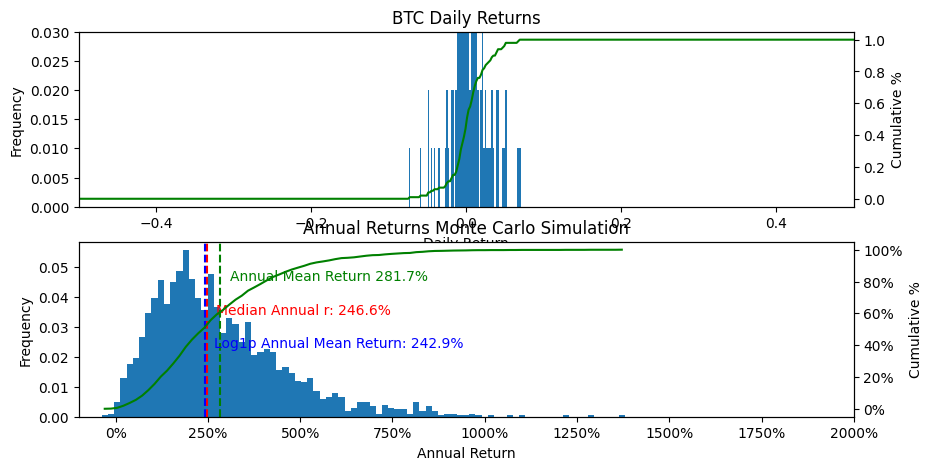

In [125]:
tail = 100
montecarlo_simulations = 2000
iterations_in_a_year = 365
min_x_daily = -0.5
max_x_daily = 0.5
bins_daily = 500
bins_yearly = 84
min_x = -1
max_x = 20

# we create two subplots, one with daily returns and one with annual returns on two rows and one column
fig, (ax0,ax1) = plt.subplots(2, 1, figsize=(10, 10))

# we plot the daily returns
# fig, ax = plt.subplots()
bin_centers, bin_counts, bin_width = get_pdf(merged_df['bitcoin_daily_return'].tail(tail), bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
# ax.hist(merged_df['bitcoin_daily_return'].tail(tail), bins=bins_daily, density=True)
ax0.bar(bin_centers, bin_counts, width=bin_width)
ax0.set_title('BTC Daily Returns')
ax0.set_xlabel('Daily Return')
ax0.set_ylabel('Frequency')
ax0.set_xlim(min_x_daily, max_x_daily)
ax0.set_ylim(0, 0.03)

# we add vertical bar for the 50th percentile
ax0.axvline(np.percentile(merged_df['bitcoin_daily_return'], 50), color='r', linestyle='--', label='50th percentile')
median = np.percentile(merged_df['bitcoin_daily_return'], 50)
ax0.text(np.percentile(merged_df['bitcoin_daily_return'], 50)*1.1, ax.get_ylim()[1]*0.9, 'Median Annual Return: {:0.1%}'.format(median), rotation=0, verticalalignment='bottom', c='r')



# we calculate the cumulative percentage
cum_pct = np.cumsum(bin_counts)
ax2 = ax0.twinx()
ax2.plot(bin_centers, cum_pct, color='green', label='Cumulative %')
ax2.set_ylabel('Cumulative %')



median, annual_centers_btc, annual_counts_btc, bin_width_btc, annual_returns_btc = get_stochastic_annual_median_return(merged_df['bitcoin_daily_return'].tail(tail),montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)


# we plot the annual returns
# fig, ax = plt.subplots()
ax1.bar(annual_centers_btc, annual_counts_btc, width=bin_width_btc)
ax1.set_title('Annual Returns Monte Carlo Simulation')
ax1.set_xlabel('Annual Return')
ax1.set_ylabel('Frequency')

y_max = ax1.get_ylim()[1]*0.95

# we add vertical bar for the 50th percentile
ax1.axvline(np.percentile(annual_returns_btc, 50), color='r', linestyle='--', label='50th percentile')
# we annotate the 50th percentile
median = np.percentile(annual_returns_btc, 50)

# we add a green vertical line for the mean as the dot product of the bin_centers and bin_counts
mean = np.dot(annual_centers_btc, annual_counts_btc)
ax1.axvline(mean, color='g', linestyle='--', label='Mean')
ax1.text(mean*1.1, y_max*0.8, 'Annual Mean Return {:0.1%}'.format(mean), rotation=0, verticalalignment='bottom', c='g')

# we add the log1p mean return as a vertical line
log1p_mean = np.dot(np.log1p(annual_centers_btc), annual_counts_btc)
log_mean = np.expm1(log1p_mean)
ax1.axvline(log_mean, color='b', linestyle='--', label='Log Mean')
ax1.text(log_mean*1.1, y_max*0.4, 'Log1p Annual Mean Return: {:0.1%}'.format(log_mean), rotation=0, verticalalignment='bottom', c='b')





ax1.text(np.percentile(annual_returns_btc, 50)*1.1, y_max*0.6, 'Median Annual r: {:0.1%}'.format(median), rotation=0, verticalalignment='bottom', c='r')

# we calculate the cumulative percentage
cum_pct = np.cumsum(annual_counts_btc)
# we plot the cumulative percentage
ax12 = ax1.twinx()
ax12.plot(annual_centers_btc, cum_pct, color='green', label='Cumulative %')
ax12.set_ylabel('Cumulative %')
ax12.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
ax12.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# we set xlim from -1 to 5
ax1.set_xlim(min_x, max_x)
fig.set_size_inches(10, 5)



plt.show()


In [20]:
# we rename date to Date
merged_df = merged_df.rename(columns={"date": "Date"})
merged_df.tail()

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
2995,2024-02-16,51958.230291,19.947655,2826.821476,113.599394,7.497789,0.003245,0.003240,0.016706,0.016568,-0.028867,-0.029292,0.090753,0.086868,-0.015728,-0.015853
2996,2024-02-17,52166.434310,19.567520,2807.371703,110.501551,7.451381,0.004007,0.003999,-0.006880,-0.006904,-0.027270,-0.027649,-0.006190,-0.006209,-0.019057,-0.019241
2997,2024-02-18,51684.517493,20.033304,2788.561332,108.928510,7.754282,-0.009238,-0.009281,-0.006700,-0.006723,-0.014235,-0.014338,0.040650,0.039846,0.023804,0.023525
2998,2024-02-19,52138.485789,20.089966,2874.945276,112.215416,7.640406,0.008783,0.008745,0.030978,0.030508,0.030175,0.029729,-0.014686,-0.014794,0.002828,0.002824
2999,2024-02-20,51764.313185,19.823360,2943.723085,111.278089,7.700477,-0.007177,-0.007202,0.023923,0.023641,-0.008353,-0.008388,0.007862,0.007832,-0.013271,-0.013359


In [21]:
print(coins)

['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']


In [22]:

def add_annual_stochastic_returns(date,merged_df, annualization_window_tail_days,information_window_tail_days, montecarlo_simulations, coins, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly):
    date = pd.to_datetime(date)
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    merged_df=merged_df[merged_df['Date'] <= date]
    min_tail_date = date - pd.DateOffset(days=annualization_window_tail_days+information_window_tail_days)
    merged_df=merged_df[(merged_df['Date'] >= min_tail_date)]
   

    for coin in coins:

        # print(tail_date)

        # for row in merged_df[(merged_df['Date'] >= tail_date) & (merged_df['Date'] <= date)].itertuples():
        for row in merged_df.itertuples():
            date = row.Date
            median_yearly, _, _,_, _ = get_stochastic_annual_median_return(merged_df[coin+'_daily_return'], montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)
            merged_df.loc[merged_df['Date'] == date, coin+'_yearly_return'] = median_yearly
        
    return merged_df


In [23]:
tail = 90 #days of data to use to estimate the yearly returns using the montecarlo simulation
montecarlo_simulations = 1000
iterations_in_a_year = 365
min_x = -1
max_x = 10
min_x_daily = -0.5
max_x_daily = 1
bins_daily = 600
bins_yearly = 90
swan_size = -1
swan_frequency = 1/10
information_window_tail_days = 5
annualization_window_tail_days = 5
y_max = 0.5

date_test = pd.to_datetime('2024-01-01').date()
df = add_annual_stochastic_returns(date_test,merged_df, annualization_window_tail_days,information_window_tail_days, montecarlo_simulations, coins, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)
df.tail(15)

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,...,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return,bitcoin_yearly_return,ethereum_yearly_return,solana_yearly_return,uniswap_yearly_return,chainlink_yearly_return
2939,2023-12-22,43849.699599,15.279277,2236.186962,93.938076,6.169052,0.004941,0.004928,0.017178,0.017033,...,0.134716,0.040970,0.040153,0.075346,0.072642,-0.679126,2.828604,843.989807,618.883899,3.896975
2940,2023-12-23,44003.696022,15.497920,2327.048963,98.078002,6.401297,0.003512,0.003506,0.040633,0.039829,...,0.043127,0.037647,0.036956,0.014310,0.014208,-0.683669,2.655601,969.611277,627.041984,3.917017
2941,2023-12-24,43752.030885,15.681732,2310.955663,107.639817,6.334079,-0.005719,-0.005736,-0.006916,-0.006940,...,0.093028,-0.010501,-0.010556,0.011860,0.011791,-0.685160,2.824754,913.656313,622.687917,3.730623
2942,2023-12-25,43034.971063,15.291259,2264.911144,112.448358,6.854675,-0.016389,-0.016525,-0.019924,-0.020126,...,0.043703,0.082190,0.078986,-0.024900,-0.025215,-0.686722,2.911710,797.464270,626.965718,3.896518
2943,2023-12-26,43638.236302,15.612646,2273.632612,121.446593,6.972945,0.014018,0.013921,0.003851,0.003843,...,0.076981,0.017254,0.017107,0.021018,0.020800,-0.679519,2.748395,901.466581,594.248013,3.985748
2944,2023-12-27,42516.426940,15.068265,2230.876184,112.325516,7.314333,-0.025707,-0.026043,-0.018805,-0.018984,...,-0.078074,0.048959,0.047798,-0.034868,-0.035490,-0.684642,2.670274,933.789068,613.066389,4.076367
2945,2023-12-28,43418.467775,16.642370,2376.771249,106.977054,7.242607,0.021216,0.020994,0.065398,0.063349,...,-0.048787,-0.009806,-0.009855,0.104465,0.099361,-0.686835,2.783140,902.779660,631.508322,4.160997
2946,2023-12-29,42600.650633,16.051461,2345.260709,102.253825,7.785611,-0.018836,-0.019015,-0.013258,-0.013346,...,-0.045156,0.074974,0.072296,-0.035506,-0.036152,-0.687324,2.852197,910.324508,622.120089,3.792954
2947,2023-12-30,42074.707156,15.528248,2299.526207,106.252561,7.564944,-0.012346,-0.012423,-0.019501,-0.019693,...,0.038361,-0.028343,-0.028752,-0.032596,-0.033139,-0.684414,2.757716,921.030242,638.366460,4.086803
2948,2023-12-31,42220.611401,15.197977,2294.344006,101.988835,7.387026,0.003468,0.003462,-0.002254,-0.002256,...,-0.040956,-0.023519,-0.023800,-0.021269,-0.021498,-0.686451,2.715216,937.724119,629.425696,3.958563


In [24]:
df.tail(65)

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,...,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return,bitcoin_yearly_return,ethereum_yearly_return,solana_yearly_return,uniswap_yearly_return,chainlink_yearly_return
2939,2023-12-22,43849.699599,15.279277,2236.186962,93.938076,6.169052,0.004941,0.004928,0.017178,0.017033,...,0.134716,0.040970,0.040153,0.075346,0.072642,-0.679126,2.828604,843.989807,618.883899,3.896975
2940,2023-12-23,44003.696022,15.497920,2327.048963,98.078002,6.401297,0.003512,0.003506,0.040633,0.039829,...,0.043127,0.037647,0.036956,0.014310,0.014208,-0.683669,2.655601,969.611277,627.041984,3.917017
2941,2023-12-24,43752.030885,15.681732,2310.955663,107.639817,6.334079,-0.005719,-0.005736,-0.006916,-0.006940,...,0.093028,-0.010501,-0.010556,0.011860,0.011791,-0.685160,2.824754,913.656313,622.687917,3.730623
2942,2023-12-25,43034.971063,15.291259,2264.911144,112.448358,6.854675,-0.016389,-0.016525,-0.019924,-0.020126,...,0.043703,0.082190,0.078986,-0.024900,-0.025215,-0.686722,2.911710,797.464270,626.965718,3.896518
2943,2023-12-26,43638.236302,15.612646,2273.632612,121.446593,6.972945,0.014018,0.013921,0.003851,0.003843,...,0.076981,0.017254,0.017107,0.021018,0.020800,-0.679519,2.748395,901.466581,594.248013,3.985748
2944,2023-12-27,42516.426940,15.068265,2230.876184,112.325516,7.314333,-0.025707,-0.026043,-0.018805,-0.018984,...,-0.078074,0.048959,0.047798,-0.034868,-0.035490,-0.684642,2.670274,933.789068,613.066389,4.076367
2945,2023-12-28,43418.467775,16.642370,2376.771249,106.977054,7.242607,0.021216,0.020994,0.065398,0.063349,...,-0.048787,-0.009806,-0.009855,0.104465,0.099361,-0.686835,2.783140,902.779660,631.508322,4.160997
2946,2023-12-29,42600.650633,16.051461,2345.260709,102.253825,7.785611,-0.018836,-0.019015,-0.013258,-0.013346,...,-0.045156,0.074974,0.072296,-0.035506,-0.036152,-0.687324,2.852197,910.324508,622.120089,3.792954
2947,2023-12-30,42074.707156,15.528248,2299.526207,106.252561,7.564944,-0.012346,-0.012423,-0.019501,-0.019693,...,0.038361,-0.028343,-0.028752,-0.032596,-0.033139,-0.684414,2.757716,921.030242,638.366460,4.086803
2948,2023-12-31,42220.611401,15.197977,2294.344006,101.988835,7.387026,0.003468,0.003462,-0.002254,-0.002256,...,-0.040956,-0.023519,-0.023800,-0.021269,-0.021498,-0.686451,2.715216,937.724119,629.425696,3.958563


In [25]:

# Define the find_nearest function
def find_nearest(all_dates, target_date):
    # Calculate the absolute difference between each date in all_dates and the target_date
    differences = [abs(date - target_date) for date in all_dates]
    # Find the index of the smallest difference
    index_nearest = differences.index(min(differences))
    return index_nearest



In [373]:
def add_swan(bin_centers, counts, swan_size, swan_frequency, swan_f = 1):
    bin_centers = bin_centers.tolist()
    counts = counts.tolist()
    if swan_frequency > 0:
        # swan_size = -(1-1e-6) if swan_size == -1 else swan_size
        bin_centers.append(swan_size*swan_f)
        counts.append(swan_frequency)
        # we normalize the array_2
        counts = np.array(counts) / np.sum(counts)
    # bin_centers_spy = np.sort(bin_centers_spy)
    bin_centers = np.array(bin_centers)
    counts = np.array(counts)
    return bin_centers, counts

def add_log_swan(bin_centers, counts, swan_size, swan_frequency, swan_f=1):
    bin_centers = bin_centers.tolist()
    counts = counts.tolist()
    
    if swan_frequency > 0:
        bin_centers.append(np.log1p(swan_size*swan_f))
        counts.append(swan_frequency)
        counts = np.array(counts) / np.sum(counts)
        
    return bin_centers, counts

HOLA GERMÀ - NECESSITES EN AQUEST PUNT QUE UPDATE 8 generi 3 coses verticals per barba

In [27]:
merged_df.tail()

coin,Date,bitcoin,chainlink,ethereum,solana,uniswap,bitcoin_daily_return,bitcoin_daily_log1p_return,ethereum_daily_return,ethereum_daily_log1p_return,solana_daily_return,solana_daily_log1p_return,uniswap_daily_return,uniswap_daily_log1p_return,chainlink_daily_return,chainlink_daily_log1p_return
2995,2024-02-16,51958.230291,19.947655,2826.821476,113.599394,7.497789,0.003245,0.003240,0.016706,0.016568,-0.028867,-0.029292,0.090753,0.086868,-0.015728,-0.015853
2996,2024-02-17,52166.434310,19.567520,2807.371703,110.501551,7.451381,0.004007,0.003999,-0.006880,-0.006904,-0.027270,-0.027649,-0.006190,-0.006209,-0.019057,-0.019241
2997,2024-02-18,51684.517493,20.033304,2788.561332,108.928510,7.754282,-0.009238,-0.009281,-0.006700,-0.006723,-0.014235,-0.014338,0.040650,0.039846,0.023804,0.023525
2998,2024-02-19,52138.485789,20.089966,2874.945276,112.215416,7.640406,0.008783,0.008745,0.030978,0.030508,0.030175,0.029729,-0.014686,-0.014794,0.002828,0.002824
2999,2024-02-20,51764.313185,19.823360,2943.723085,111.278089,7.700477,-0.007177,-0.007202,0.023923,0.023641,-0.008353,-0.008388,0.007862,0.007832,-0.013271,-0.013359


In [453]:
def process_kelly(bin_kelly_fractions, annual_bin_centers, annual_counts):
    annual_bin_centers_swan, annual_counts_swan = add_swan(annual_bin_centers, annual_counts, swan_size, swan_frequency)

    exp_g_array = []
    fr = np.linspace(0,1,bin_kelly_fractions)
    for f in fr:
        annual_bin_centers_swan_f = annual_bin_centers_swan * f
        annual_bin_centers_swan_log_f = np.log1p(annual_bin_centers_swan_f)
        exp_g = np.dot(annual_bin_centers_swan_log_f, annual_counts_swan)
        exp_g = np.expm1(exp_g)
        exp_g_array.append(exp_g)
    max_f = fr[np.argmax(exp_g_array)]
    max_g = np.max(exp_g_array)
    return max_f, exp_g_array, fr, max_g

In [488]:
def get_ax1_chart(ax1, daily_bin_centers, daily_counts, daily_bin_width, min_x_daily, max_x_daily, y_max_ax1,date):
    ax1.bar(daily_bin_centers, daily_counts, width=daily_bin_width, align='center') 
    ax1.set_title(f"Daily Returns Distribution {information_window_tail_days} days ending in {date.strftime('%Y-%m-%d')}")
    ax1.set_xlabel('Daily Return')
    ax1.set_ylabel('Frequency')
    ax1.set_xlim(min_x_daily*0.5, max_x_daily*0.2)
    ax1.set_ylim(0.001, y_max_ax1)
    ax1.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    ax1.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    return ax1


def get_ax2_chart(ax2, annual_centers, annual_counts, annual_bin_width, min_x, max_x, y_max_ax2, log_mean_e, coin, log_mean, index_for):
    ax2.bar(annual_centers, annual_counts, width=annual_bin_width, align='center')  # align='center' to center the bars
    ax2.axvline(x=log_mean_e if log_mean_e < max_x else max_x, color='g' if log_mean_e > 0 else 'r', linestyle='--', label='Mean return')
    ax2.set_title(f"Annual Returns Distribution last {information_window_tail_days} days")
    ax2.set_xlabel('Annual Return')
    ax2.set_ylabel('Frequency')
    ax2.set_xlim(min_x, max_x)
    ax2.set_ylim(0.001, y_max_ax2)
    ax2.text(log_mean_e, y_max_ax2*0.9*(1-0.1*index_for), f'{coin}: {log_mean_e*100:.0f}%', rotation=0, verticalalignment='bottom', horizontalalignment='left' if log_mean < 0 else 'right', color='g' if log_mean_e > 0 else 'r', fontsize=6)
    ax2.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    ax2.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    return ax2
        
def get_ax3_chart(ax3, max_f, exp_g_array, fr, ax3_ymax, coin):
    ax3.plot(fr, exp_g_array)
    max_g = np.max(exp_g_array)
    ax3.axvline(x=max_f if max_f < 1 else 1, color='g', linestyle='--', label='Max G')
    ax3.text(max_f, max_g if max_g < ax3_ymax else ax3_ymax, f"{coin}: {max_f*100:.0f}% ", rotation=0, verticalalignment='bottom', horizontalalignment='right' if max_f > 0.5 else 'left', color='g', fontsize=6)
    ax3.set_title(f"Expected G as function of fraction")
    ax3.set_xlabel('Fraction')
    ax3.set_ylabel('Expected G')
    ax3.set_xlim(0, 1)
    ax3.set_ylim(-1,ax3_ymax)
    ax3.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    ax3.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    
    return ax3


# we make titles smaller size
def set_fontsize_params(ax, title_size=10, label_size=8, tick_size=8):
    ax.title.set_size(10)
    ax.xaxis.label.set_size(8)
    ax.yaxis.label.set_size(8)
    ax.tick_params(axis='both', which='major', labelsize=8)
    return ax


In [454]:

def get_3charts(date,merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max_ax2,y_max_ax1, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,ax3_ymax,frame_prefix=None):
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    date = pd.to_datetime(date)

    information_window_df = merged_df[merged_df['Date'] < date]
    information_window_df = information_window_df.tail(information_window_tail_days)
    fig, (ax1, ax2,  ax3) = plt.subplots(3, 1, figsize=(8, 6))

    for coin in coins:
        index_for = coins.index(coin)
        daily_bin_centers, daily_counts, daily_bin_width = get_pdf(information_window_df[coin+'_daily_return'], bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
        _, annual_centers, annual_counts, annual_bin_width, log_mean_e = get_stochastic_annual_median_return(information_window_df[coin+'_daily_return'],montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)
        max_f, exp_g_array, fr, max_g = process_kelly(bin_kelly_fractions, annual_centers, annual_counts)

        ax1 = get_ax1_chart(ax1, daily_bin_centers, daily_counts, daily_bin_width, min_x_daily, max_x_daily, y_max_ax1)
        ax2 = get_ax2_chart(ax2, annual_centers, annual_counts, annual_bin_width, min_x, max_x, y_max_ax2, log_mean_e, coin, log_mean, index_for)
        ax3 = get_ax3_chart(ax3, max_f, exp_g_array, fr, ax3_ymax, coin)

        title_size=10
        label_size=8
        tick_size=8
        args = (title_size, label_size, tick_size) 
        ax1 = set_fontsize_params(ax1, *args)
        ax2 = set_fontsize_params(ax2, *args)
        ax3 = set_fontsize_params(ax3, *args)

    plt.tight_layout() 
    plt.subplots_adjust(hspace=0.8)
    fig.savefig(f"{frame_prefix}_ax1.png")
    return fig, ax1, ax2, ax3
    


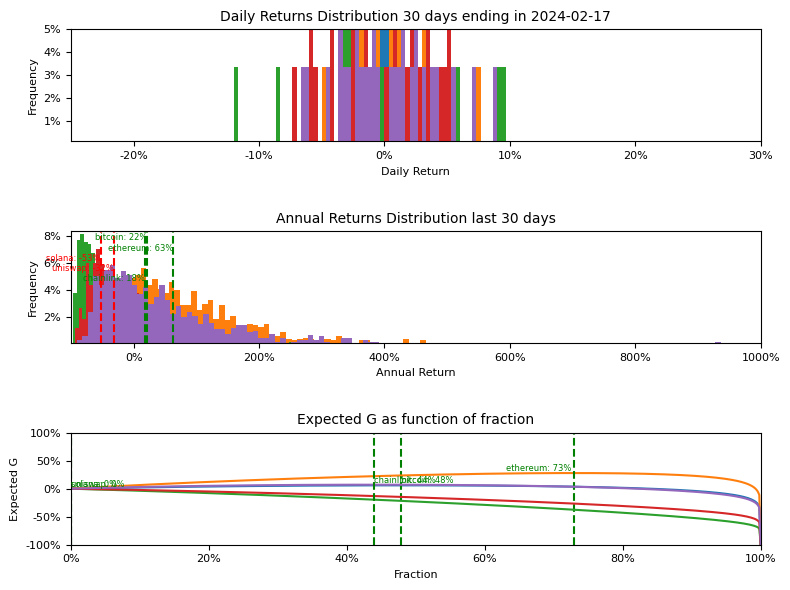

In [455]:
montecarlo_simulations = 1000
coins = ['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']
min_x = -1
max_x = 10
bins_yearly = 120
min_x_daily = -0.5
max_x_daily = 1.5
bins_daily = 600
bin_kelly_fractions = 500
y_max_ax1 = 0.05
y_max_ax2 = 1/bins_yearly*10#0.05
y_max_ax3 = 1

swan_size = -1
swan_frequency = 1/10


information_window_tail_days = 30
calc_date = pd.to_datetime('2023-03-01').date()


fig, ax1, ax3, ax5 = get_3charts(calc_date, merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max_ax2,y_max_ax1, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,y_max_ax3)



In [499]:
def get_ax4_chart(ax4, max_f, coin, max_g, ax4_ymax):
    max_g = max_g if max_g < ax4_ymax else ax4_ymax
    ax4.scatter(max_f, max_g, label='Max G')
    ax4.set_title(f"Max G and Max F")
    ax4.set_xlabel('Max Fraction')
    ax4.set_ylabel('Max G')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0,ax4_ymax)

    ax4.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    ax4.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    ax4.text(max_f+0.05, max_g+0.05, f"{coin}", rotation=0, verticalalignment='bottom', horizontalalignment='right' if max_f > 0.5 else 'left', color='g', fontsize=6)
    return ax4

In [497]:

def get_4charts(date,merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max_ax2,y_max_ax1, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,ax3_ymax,ax4_ymax,frame_prefix=None):
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    date = pd.to_datetime(date)

    information_window_df = merged_df[merged_df['Date'] < date]
    information_window_df = information_window_df.tail(information_window_tail_days)
    fig, ((ax1,ax1r),(ax2,ax2r),(ax3,ax3r)) = plt.subplots(3, 2, figsize=(8, 6))
    max_f_array = []

    for coin in coins:
        index_for = coins.index(coin)
        daily_bin_centers, daily_counts, daily_bin_width = get_pdf(information_window_df[coin+'_daily_return'], bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
        _, annual_centers, annual_counts, annual_bin_width, log_mean_e = get_stochastic_annual_median_return(information_window_df[coin+'_daily_return'],montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)
        max_f, exp_g_array, fr, max_g = process_kelly(bin_kelly_fractions, annual_centers, annual_counts)
        max_f_array.append(max_f)

        ax1 = get_ax1_chart(ax1, daily_bin_centers, daily_counts, daily_bin_width, min_x_daily, max_x_daily, y_max_ax1,date)
        ax2 = get_ax2_chart(ax2, annual_centers, annual_counts, annual_bin_width, min_x, max_x, y_max_ax2, log_mean_e, coin, log_mean, index_for)
        ax3 = get_ax3_chart(ax3, max_f, exp_g_array, fr, ax3_ymax, coin)
        ax1r = get_ax4_chart(ax1r, max_f, coin, max_g,ax4_ymax)

        title_size=10
        label_size=8
        tick_size=8
        args = (title_size, label_size, tick_size) 
        ax1 = set_fontsize_params(ax1, *args)
        ax2 = set_fontsize_params(ax2, *args)
        ax3 = set_fontsize_params(ax3, *args)
        ax1r = set_fontsize_params(ax1r, *args)

    plt.tight_layout() 
    plt.subplots_adjust(hspace=0.8)
    fig.savefig(f"{frame_prefix}_ax1.png")
    return fig #, ax1, ax2, ax3, ax4
    


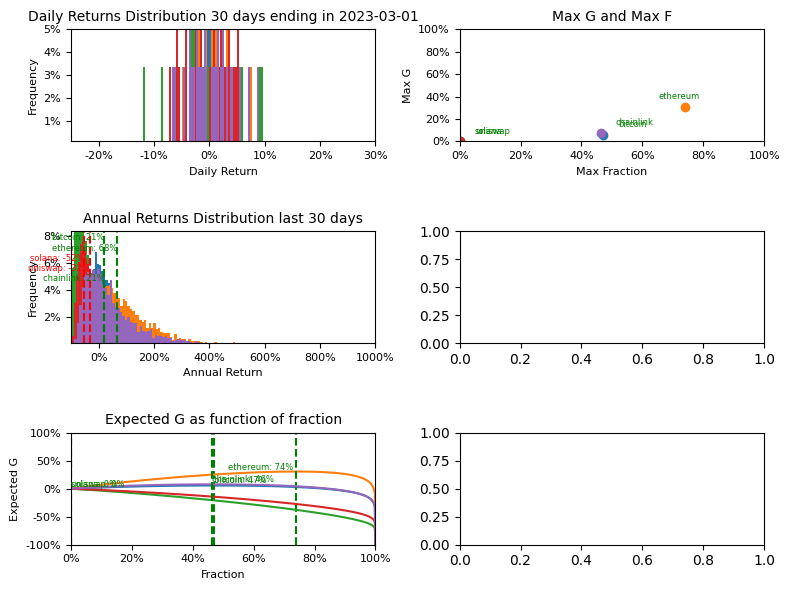

In [502]:
montecarlo_simulations = 5000
coins = ['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']
min_x = -1
max_x = 10
bins_yearly = 120
min_x_daily = -0.5
max_x_daily = 1.5
bins_daily = 600
bin_kelly_fractions = 500
y_max_ax1 = 0.05
y_max_ax2 = 1/bins_yearly*10#0.05
y_max_ax3 = 1
ax4_ymax = y_max_ax3

swan_size = -1
swan_frequency = 1/10


information_window_tail_days = 30
calc_date = pd.to_datetime('2023-03-01').date()


fig = get_4charts(calc_date, merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max_ax2,y_max_ax1, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,y_max_ax3,ax4_ymax)



In [557]:
def get_price_timeline_chart(ax2r, merged_df, information_window_df, coin, date, information_window_tail_days, min_price_date, max_price_date):
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    
    max_price_date = pd.to_datetime(max_price_date)
    min_price_date = pd.to_datetime(min_price_date)
    plot_data_df = merged_df[merged_df['Date'] <= max_price_date]
    plot_data_df = merged_df[merged_df['Date'] >= min_price_date]
    dates = plot_data_df['Date']
    # we normalize coin column by the first value
    plot_data_df[coin] = plot_data_df[coin] / plot_data_df[coin].iloc[0]
    ax2r.plot(dates, plot_data_df[coin], label=coin)
    ax2r.set_title(f"Price Timeline")
    ax2r.set_xlabel('Date')
    ax2r.set_ylabel('Price')
    ax2r.set_xlim(min_price_date, max_price_date)
    ax2r.set_ylim(0,3)
    ax2r.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
    ax2r.xaxis.set_major_locator(mdates.WeekdayLocator(interval=30))
    # we set x axis range from min_price_date to max_price_date
    


    # we add vertical line for the date
    ax2r.axvline(x=date if date <=max_price_date else max_price_date, color='r', linestyle='--', label='Date')

    # we add a shaded area for the information window
    ax2r.axvspan(date - pd.DateOffset(days=information_window_tail_days), date if date <=max_price_date else max_price_date, alpha=0.1, color='green')


    # ax2r.legend()
    return ax2r

In [ ]:
def get_entropy_g_scatter_chart(ax4, max_f_array, max_g_array, coins, ax4_ymax, coin):

    max_g = max_g_array[index_for]
    max_f = max_f_array[index_for]
    max_g = max_g if max_g < ax4_ymax else ax4_ymax
    ax4.scatter(max_f, max_g, label=coin)
    ax4.set_title(f"Max G and Max F")
    ax4.set_xlabel('Max Fraction')
    ax4.set_ylabel('Max G')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0,ax4_ymax)

    ax4.xaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    ax4.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    return ax4

In [558]:

def get_6charts(date,merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max_ax2,y_max_ax1, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,ax3_ymax,ax4_ymax,min_price_date, max_price_date,frame_prefix=None):
    merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    date = pd.to_datetime(date)

    information_window_df = merged_df[merged_df['Date'] < date]
    information_window_df = information_window_df.tail(information_window_tail_days)
    fig, ((ax1,ax1r),(ax2,ax2r),(ax3,ax3r)) = plt.subplots(3, 2, figsize=(8, 6))
    max_f_array = []

    for coin in coins:
        index_for = coins.index(coin)
        daily_bin_centers, daily_counts, daily_bin_width = get_pdf(information_window_df[coin+'_daily_return'], bins=bins_daily, min_x=min_x_daily, max_x=max_x_daily)
        _, annual_centers, annual_counts, annual_bin_width, log_mean_e = get_stochastic_annual_median_return(information_window_df[coin+'_daily_return'],montecarlo_simulations, iterations_in_a_year, min_x, max_x, min_x_daily, max_x_daily, bins_daily, bins_yearly)
        max_f, exp_g_array, fr, max_g = process_kelly(bin_kelly_fractions, annual_centers, annual_counts)
        max_f_array.append(max_f)
        entropy
        
        ax1 = get_ax1_chart(ax1, daily_bin_centers, daily_counts, daily_bin_width, min_x_daily, max_x_daily, y_max_ax1,date)
        ax2 = get_ax2_chart(ax2, annual_centers, annual_counts, annual_bin_width, min_x, max_x, y_max_ax2, log_mean_e, coin, log_mean, index_for)
        ax3 = get_ax3_chart(ax3, max_f, exp_g_array, fr, ax3_ymax, coin)
        ax1r = get_ax4_chart(ax1r, max_f, coin, max_g,ax4_ymax)
        ax2r = get_price_timeline_chart(ax2r, merged_df, information_window_df, coin, date, information_window_tail_days, min_price_date, max_price_date)
        ax3r = get_entropy_g_scatter_chart(ax3r, max_f_array, exp_g_array, coins, ax3_ymax, coin)

        title_size=10
        label_size=8
        tick_size=8
        args = (title_size, label_size, tick_size) 
        ax1 = set_fontsize_params(ax1, *args)
        ax2 = set_fontsize_params(ax2, *args)
        ax3 = set_fontsize_params(ax3, *args)
        ax1r = set_fontsize_params(ax1r, *args)

    plt.tight_layout() 
    plt.subplots_adjust(hspace=0.8)
    fig.savefig(f"{frame_prefix}_ax1.png")
    return fig #, ax1, ax2, ax3, ax4
    


In [566]:

def make_video(start_date, sequence_length, interval_days, merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max_ax2,y_max_ax1, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,y_max_ax3,ax4_ymax,min_price_date, max_price_date):
    for i in range(sequence_length):  # For each of the three days
        new_date = start_date + timedelta(days=i*interval_days)
        frame_prefix = new_date.strftime("%Y-%m-%d")
        get_5charts(new_date, merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max_ax2,y_max_ax1, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,y_max_ax3,ax4_ymax,min_price_date, max_price_date,frame_prefix=frame_prefix)


    filenames = []
    for i in range(sequence_length):  # For each of the three days
        new_date = start_date + timedelta(days=i*interval_days)
        frame_prefix = new_date.strftime("%Y-%m-%d")
        filenames.append(f"{frame_prefix}_ax1.png")

    with imageio.get_writer('charts5_log_99_BLING2.mp4', fps=1) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 600) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


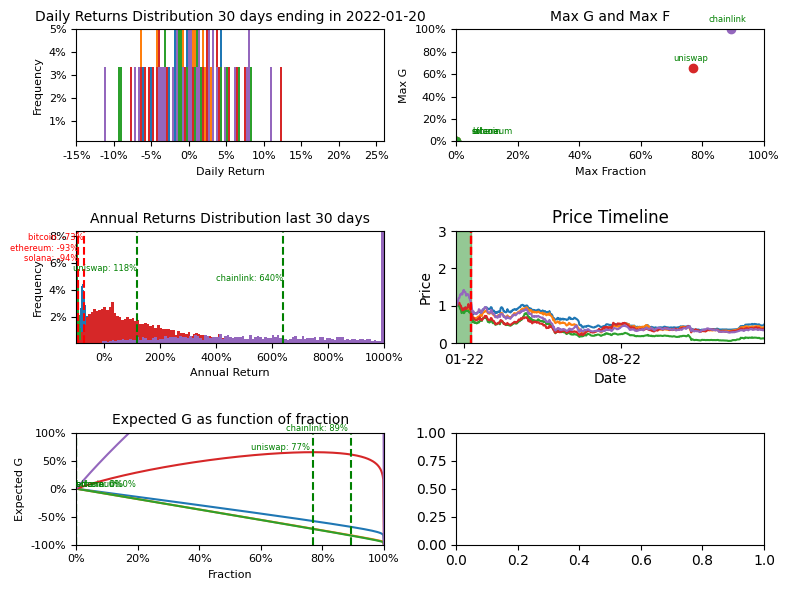

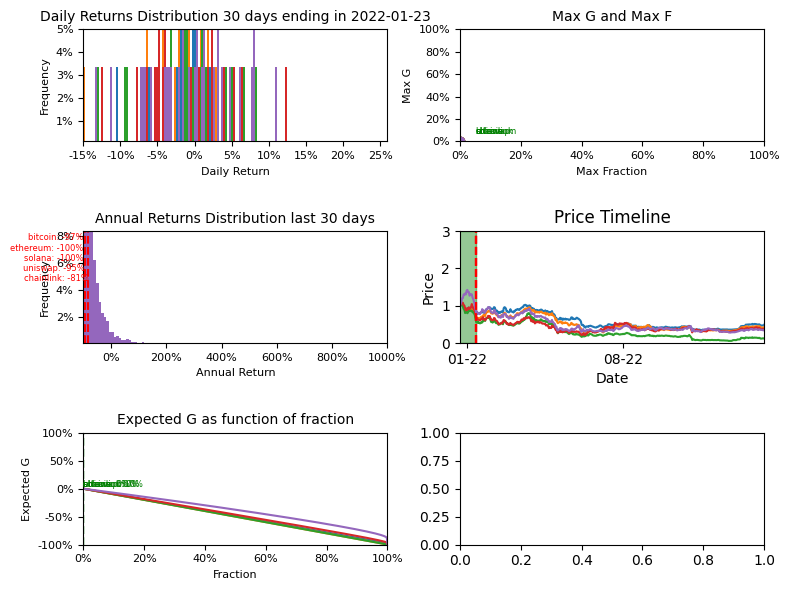

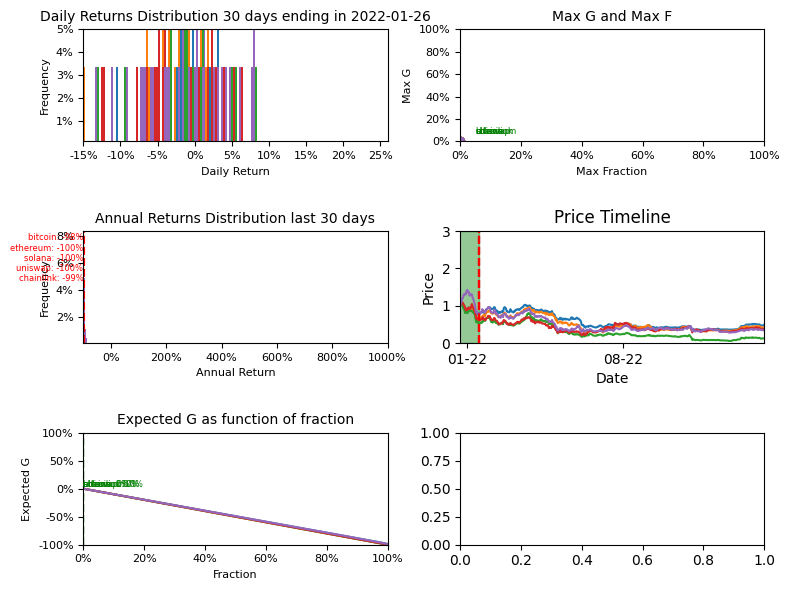

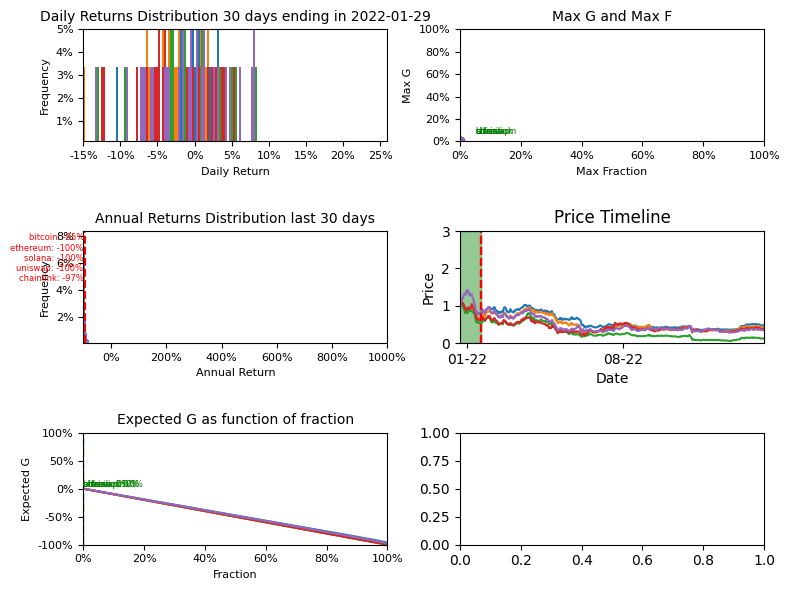

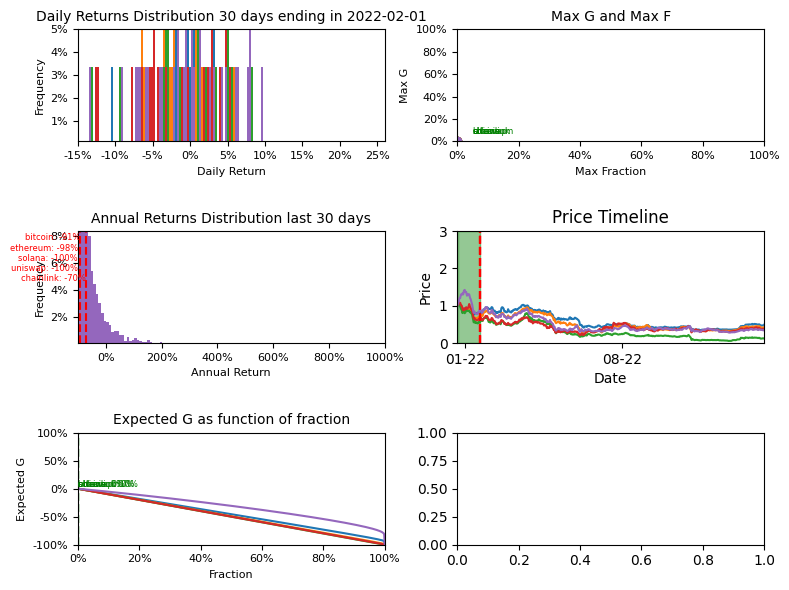

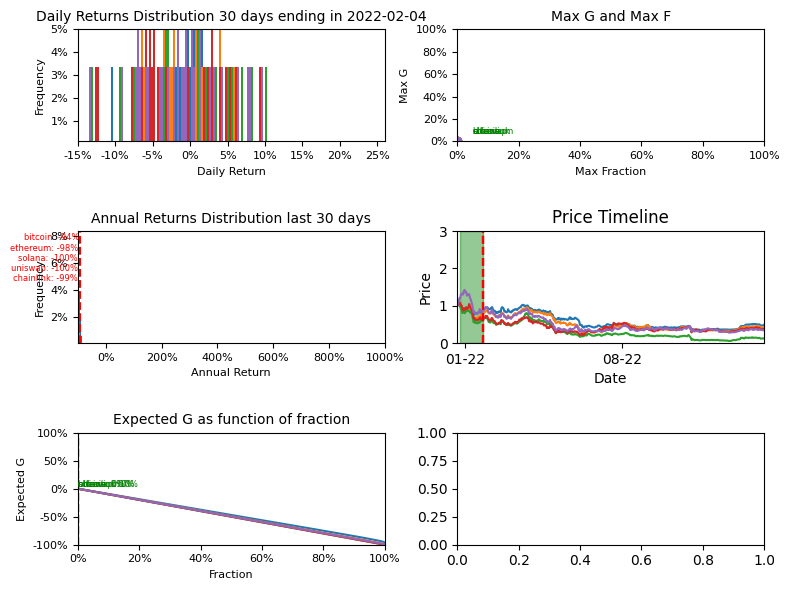

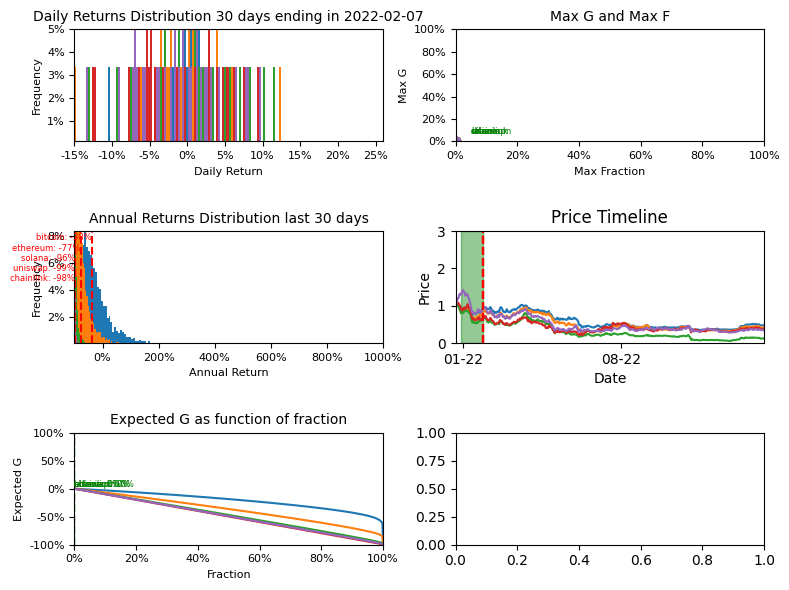

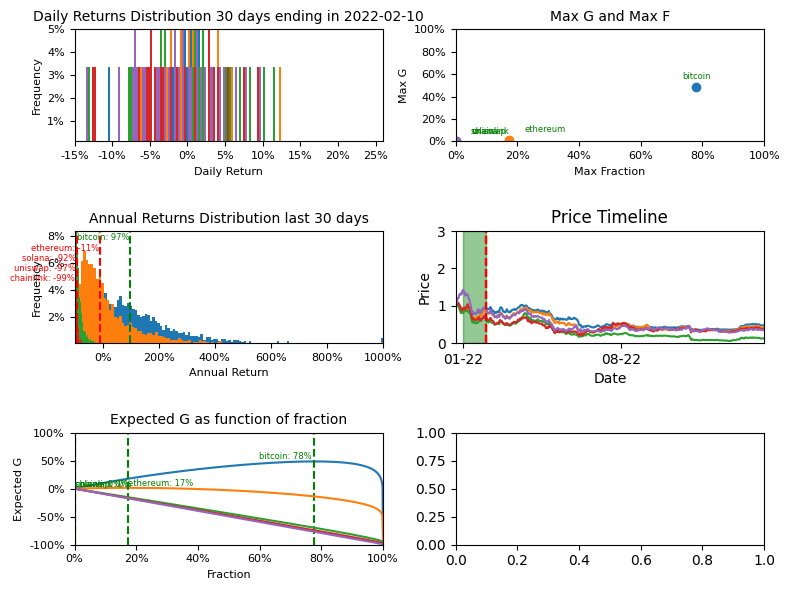

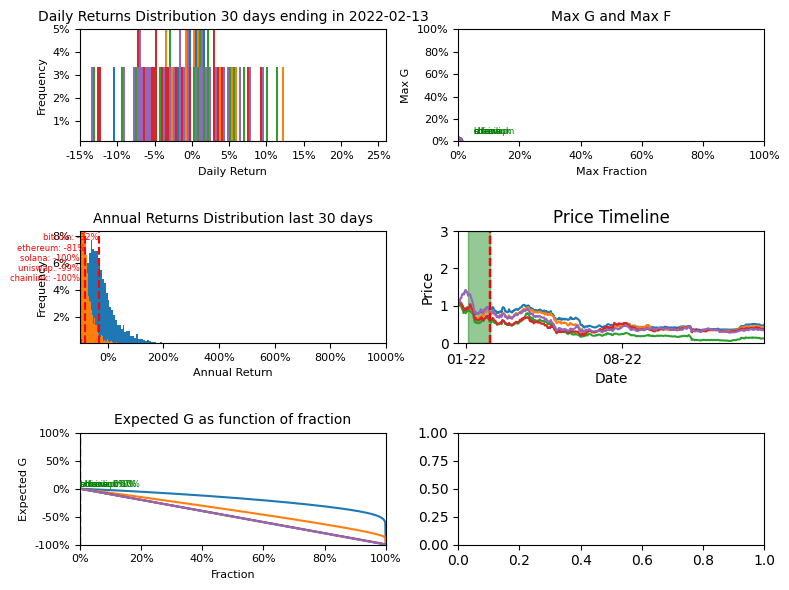

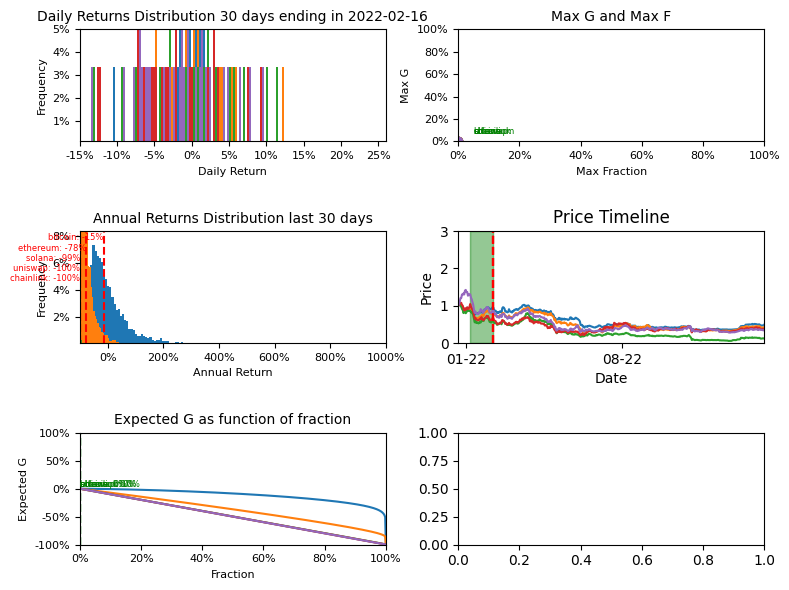

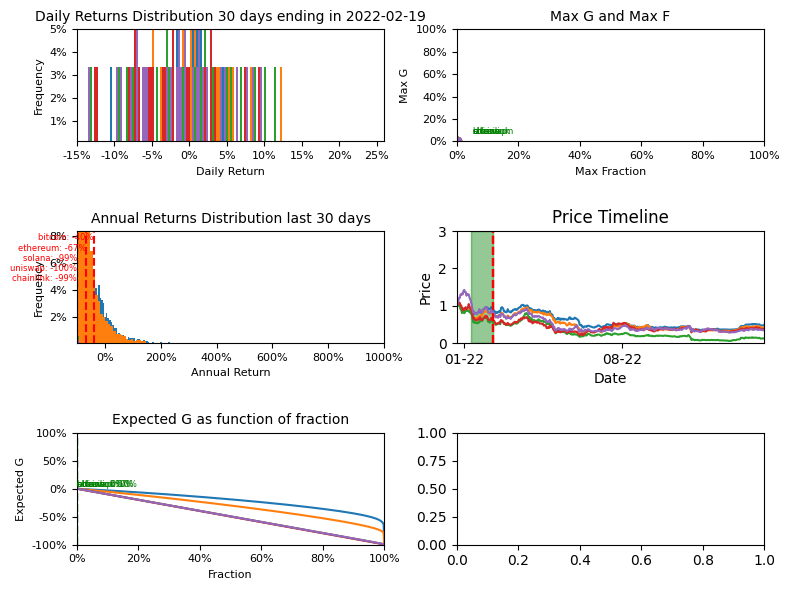

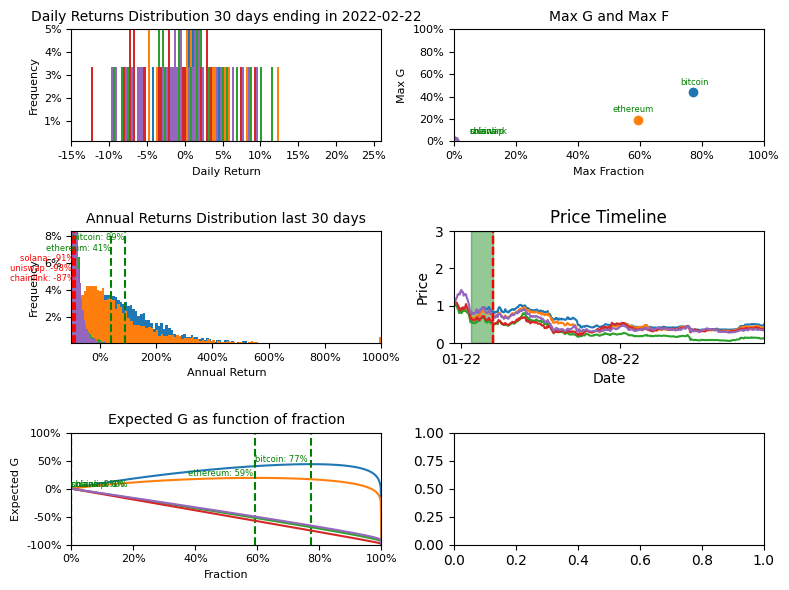

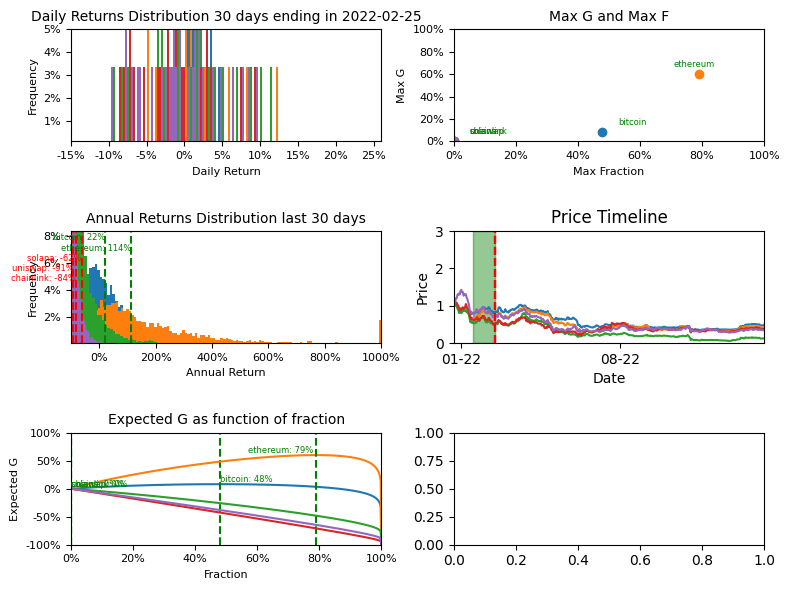

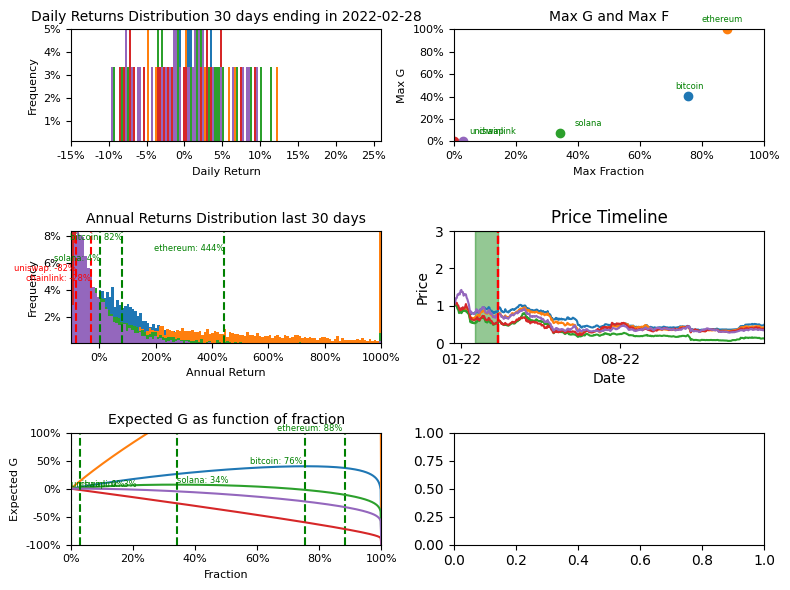

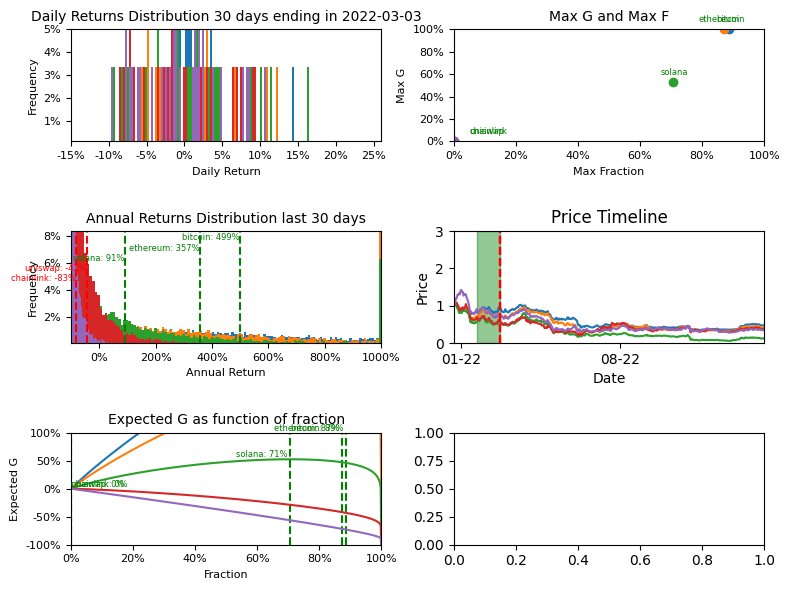

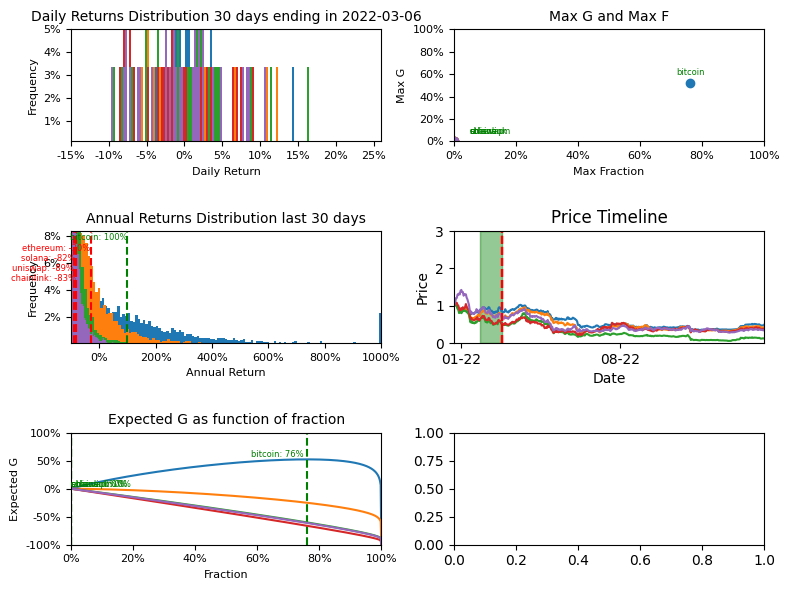

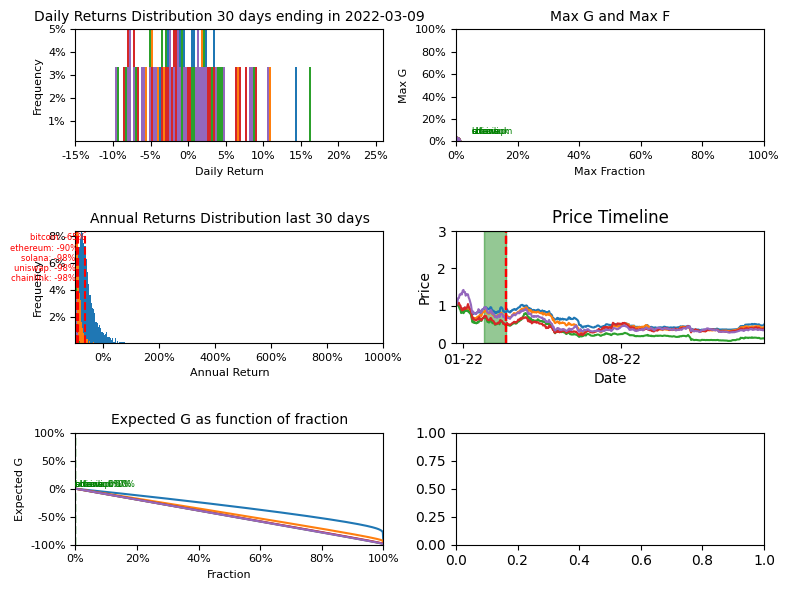

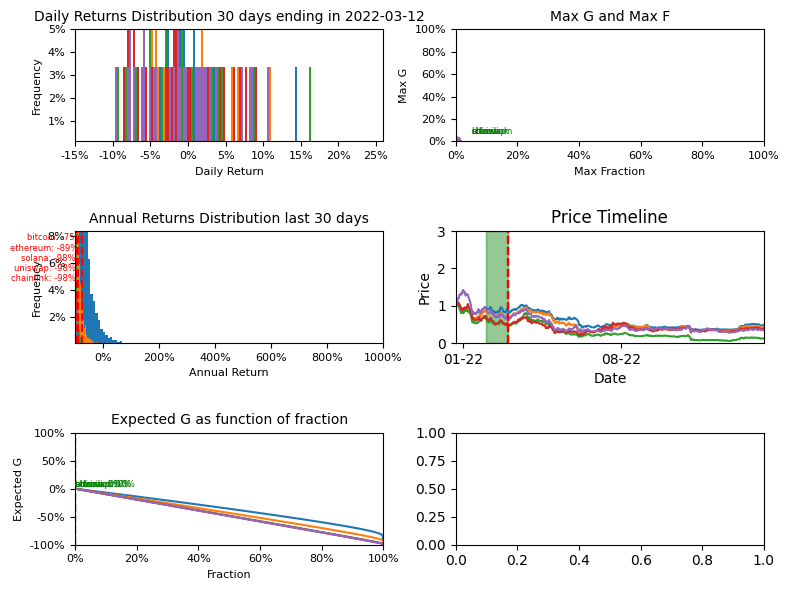

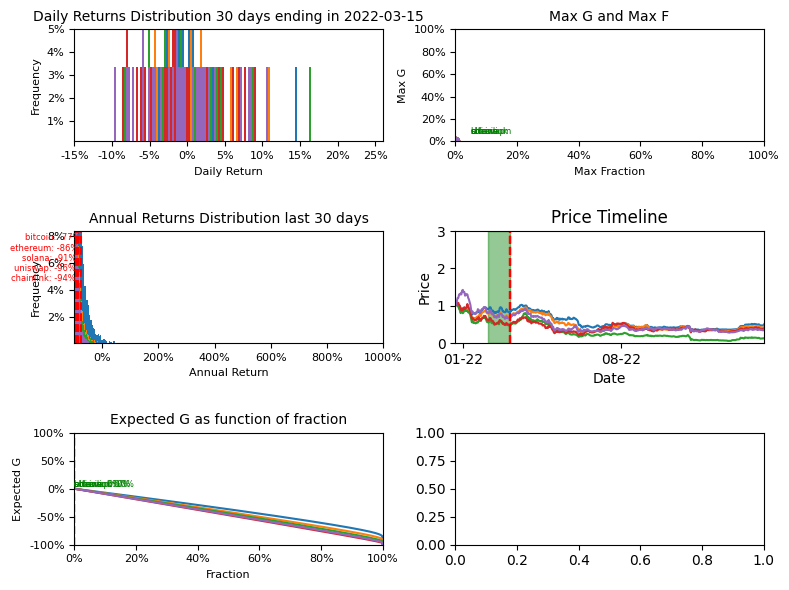

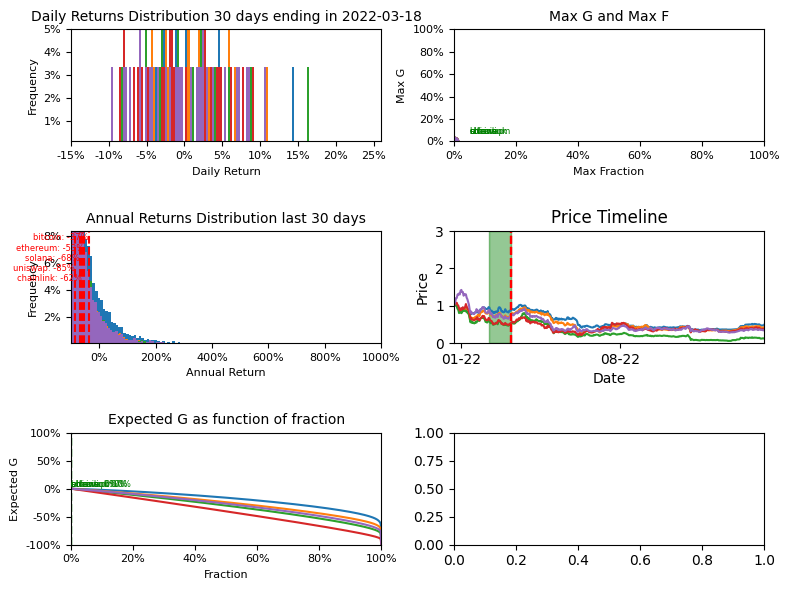

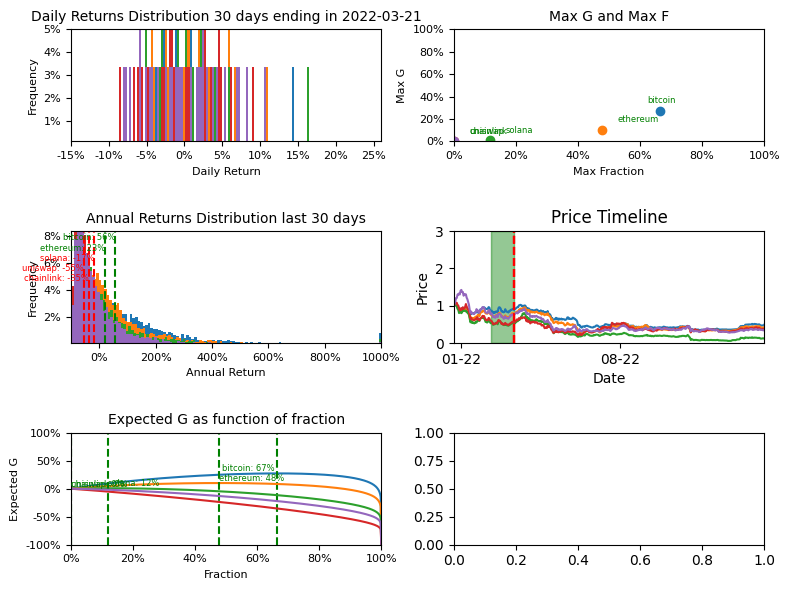

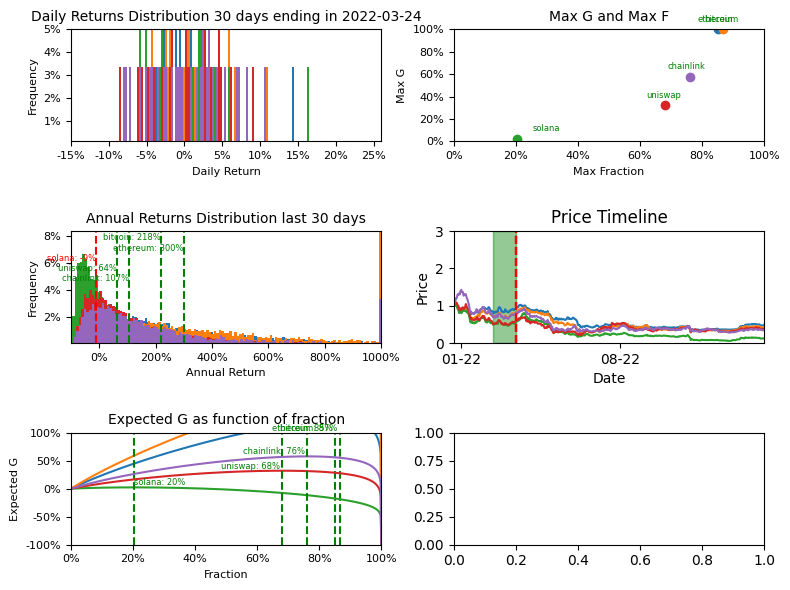

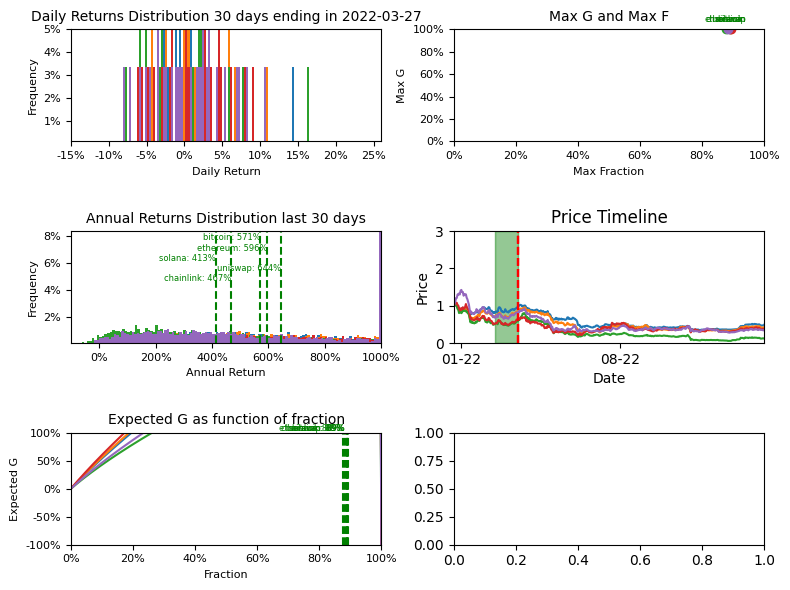

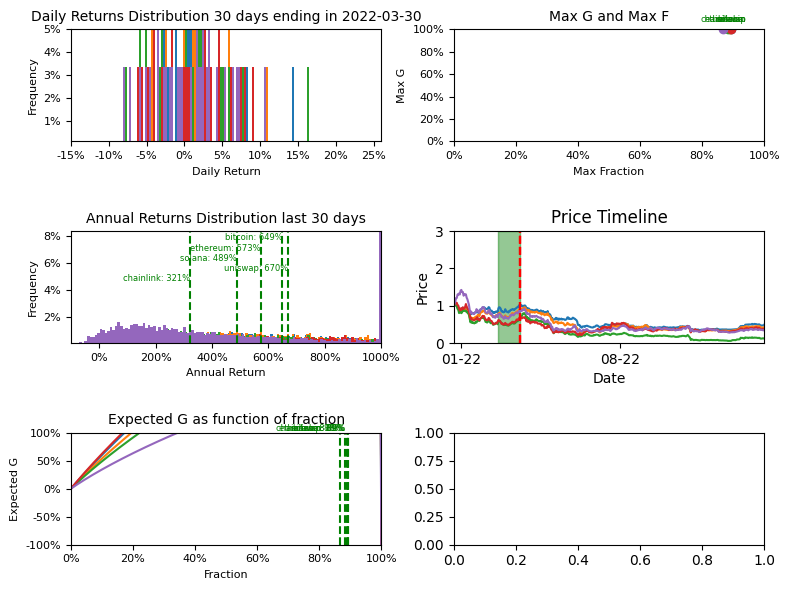

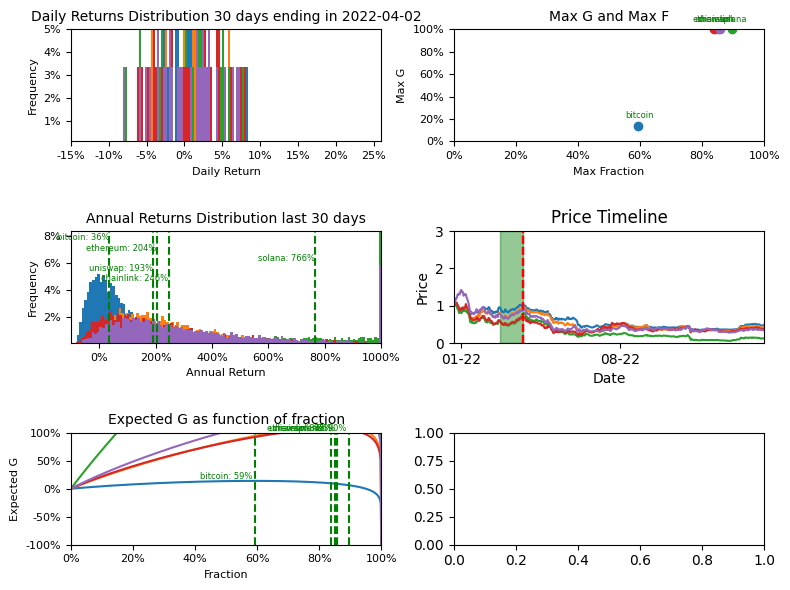

In [572]:

montecarlo_simulations = 5000
coins = ['bitcoin', 'ethereum', 'solana', 'uniswap', 'chainlink']
min_x = -1
max_x = 10
bins_yearly = 120
min_x_daily = -0.3
max_x_daily = 1.3
bins_daily = 600
bin_kelly_fractions = 500
y_max_ax1 = 0.05
y_max_ax2 = 1/bins_yearly*10#0.05
y_max_ax3 = 1
ax4_ymax = y_max_ax3

swan_size = -1
swan_frequency = 1/10

min_price_date = pd.to_datetime('2022-01-01').date()
max_price_date = pd.to_datetime('2023-02-15').date()
start_date = pd.to_datetime('2022-01-20').date()
information_window_tail_days = 30
sequence_length = 25
interval_days = 3

make_video(start_date, sequence_length, interval_days, merged_df, coins, information_window_tail_days, min_x_daily, max_x_daily, min_x, max_x, y_max_ax2,y_max_ax1, bins_daily, bins_yearly, swan_size, swan_frequency,bin_kelly_fractions,y_max_ax3,ax4_ymax,min_price_date, max_price_date)
